In [1]:
import itertools

import multiprocess
import numpy as np
import pymatching
import scipy.optimize
import stim
from matplotlib import pyplot as plt

## Circuit

In [2]:
distance = 5
rounds = 20
circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    distance=distance,
    rounds=rounds,
    after_clifford_depolarization=1e-2,
    after_reset_flip_probability=1e-2,
    before_measure_flip_probability=1e-2,
    before_round_data_depolarization=1e-2,
)
with open("surface-code-timeline.svg", "w") as f:
    f.write(str(circuit.without_noise().diagram("timeline-svg")))

In [3]:
def calc_def(circuit: stim.Circuit, sample: np.ndarray, distance: int, rounds: int):
    res = {}
    for key, (i, j, _) in circuit.get_detector_coordinates().items():
        i = int(i / 2)
        j = int(j / 2)
        if (i, j) not in res:
            res[(i, j)] = [sample[key]]
        else:
            res[(i, j)].append(sample[key])
    heatmap = np.zeros((distance + 1, distance + 1))
    heatmap.fill(np.nan)
    for (i, j), val in res.items():
        if len(val) == rounds + 1:
            heatmap[i, j] = np.mean(val[1:-1])
        else:
            heatmap[i, j] = np.mean(val)
    for key, val in res.items():
        if len(val) == rounds + 1:
            res[key] = np.array([np.arange(rounds + 1), val])
        else:
            res[key] = np.array([np.arange(rounds - 1) + 1, val])
    return res, heatmap

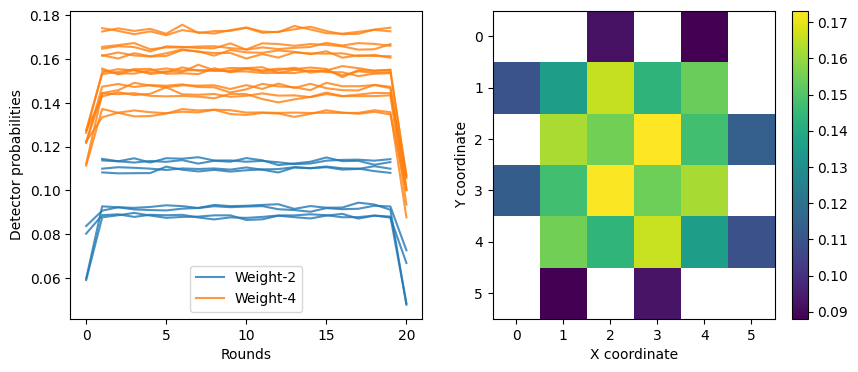

In [4]:
shots = 10**5
detector_sampler = circuit.compile_detector_sampler()
detector_sample = detector_sampler.sample(shots).mean(axis=0)
res, heatmap = calc_def(circuit, detector_sample, distance, rounds)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for key, val in res.items():
    if 0 in key or distance in key:
        axs[0].plot(val[0], val[1], color="C0", alpha=0.8, label="Weight-2")
    else:
        axs[0].plot(val[0], val[1], color="C1", alpha=0.8, label="Weight-4")
axs[0].set_xlabel("Rounds")
axs[0].set_ylabel("Detector probabilities")
handles, labels = axs[0].get_legend_handles_labels()
temp = {k: v for k, v in zip(labels, handles)}
axs[0].legend(temp.values(), temp.keys())

im = axs[1].imshow(heatmap, aspect="auto")
fig.colorbar(im, ax=axs[1])

axs[1].set_xticks(np.arange(0, distance + 1))
axs[1].set_yticks(np.arange(0, distance + 1))
axs[1].set_xlabel("X coordinate")
axs[1].set_ylabel("Y coordinate")

plt.show()